# 1.- Load libraries

In [1]:
from influxdb import DataFrameClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import requests 
from datetime import datetime
import time
import ast

# 2.- Prepare Database

In [2]:
client = DataFrameClient('localhost', 8086, 'root', 'root')

In [3]:
client.get_list_database()

[{'name': '_internal'},
 {'name': 'Market'},
 {'name': 'difBook'},
 {'name': 'demo'},
 {'name': 'Markets'}]

In [4]:
client.switch_database("Markets")

In [5]:
client.get_list_measurements()

[{'name': 'Book'}, {'name': 'Price'}, {'name': 'difBook'}]

In [6]:
points = client.query("SELECT * FROM Price WHERE time > '2020-04-29 15:10:00'")

Check times. For future analysis, we have to take the differences into account

In [7]:
# Time checks
response = requests.get('https://api.kraken.com/0/public/Time')
print("Kraken Time:   " + datetime.fromtimestamp(response.json()["result"]["unixtime"]).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.huobi.pro/v1/common/timestamp')
print("Huobi Time:    " + datetime.fromtimestamp(response.json()["data"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.pro.coinbase.com/time')
print("Coinbase Time: " + response.json()["iso"])
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://www.bitstamp.net/api/ticker/')
print("Bitstamp Time: " + datetime.fromtimestamp(int(response.json()["timestamp"])).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://global-openapi.bithumb.pro/openapi/v1/serverTime')
print("Bithumb Time:  " + datetime.fromtimestamp(response.json()["timestamp"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.kraken.com/0/public/Time')
print("Kraken Time:   " + datetime.fromtimestamp(response.json()["result"]["unixtime"]).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api-pub.bitfinex.com/v2/status/deriv?keys=tBTCF0:USTF0')
print("Bitfinex Time: " + str(datetime.fromtimestamp(response.json()[0][1]/1000)))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.binance.com/api/v1/time')
print("Binance Time:  " + datetime.fromtimestamp(response.json()["serverTime"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))

Kraken Time:   2020-04-29 20:20:58.000000
Computer Time: 2020-04-29 20:20:58.117270
------------------------------------------------------------------
Huobi Time:    2020-04-29 20:20:58.830000
Computer Time: 2020-04-29 20:20:58.615593
------------------------------------------------------------------
Coinbase Time: 2020-04-29T18:20:59.134Z
Computer Time: 2020-04-29 20:20:58.858804
------------------------------------------------------------------
Bitstamp Time: 2020-04-29 20:20:57.000000
Computer Time: 2020-04-29 20:20:59.038378
------------------------------------------------------------------
Bithumb Time:  2020-04-29 20:20:59.718000
Computer Time: 2020-04-29 20:20:59.468881
------------------------------------------------------------------
Kraken Time:   2020-04-29 20:21:00.000000
Computer Time: 2020-04-29 20:20:59.924257
------------------------------------------------------------------
Bitfinex Time: 2020-04-29 20:20:58
Computer Time: 2020-04-29 20:21:00.096833
-------------------

# Trades

### 1.1 Check for duplicates

In [8]:
#1.- Check for duplicates
dup_number = np.sum(points["Price"].iloc[:,0:4].reset_index().duplicated())

In [9]:
if dup_number != 0:
    points["Price"][points["Price"].iloc[:,0:4].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


### 1.2 Check that all exchanges and pairs are in

 bitstamp ethbtc, bitflyer

In [10]:
np.unique(points["Price"]["Host"] + " - " + points["Price"]["Pair"])

array(['Binance - ethbtc', 'Bitfinex - btcusd', 'Bitfinex - ethbtc',
       'Bitfinex - ethusd', 'Bitfinex - xtzusd', 'Bithumb - ethbtc',
       'Bitstamp - btcusd', 'Bitstamp - ethusd', 'Coinbase - btcusd',
       'Coinbase - dashusd', 'Coinbase - ethbtc', 'Coinbase - ethusd',
       'Coinbase - xtzusd', 'Huobi - ethbtc', 'Kraken - ethbtc'],
      dtype=object)

In [37]:
points["Price"].iloc[0].name

Timestamp('2020-04-29 19:37:45+0000', tz='UTC')

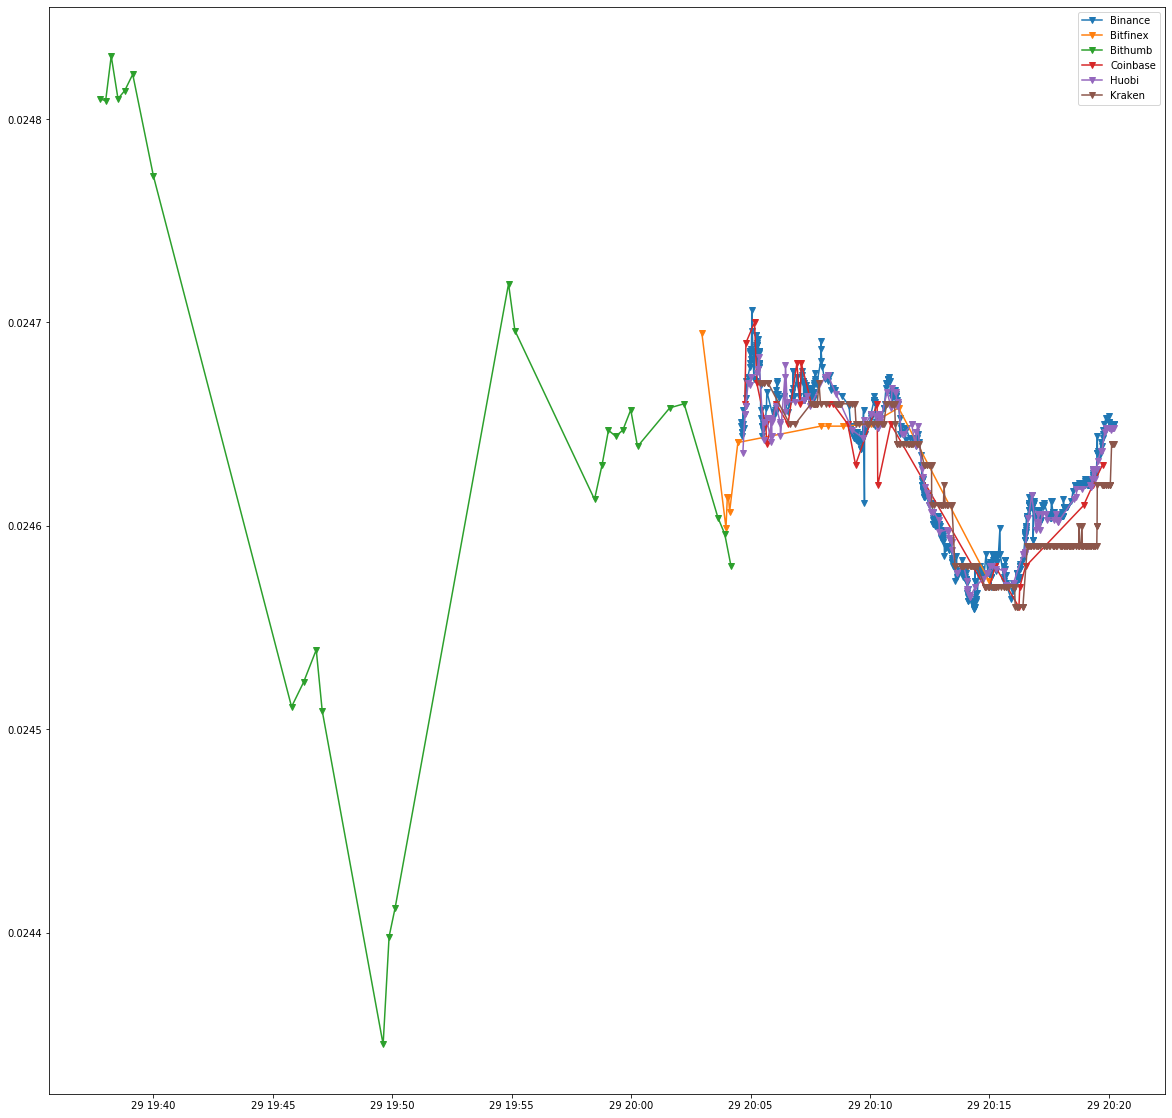

In [13]:
# Print last trades prices 
df = points["Price"][points["Price"]["Pair"] == "ethbtc"]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,20)
for k,g in df.groupby(['Host'])['Price']:
    ax.plot_date(pd.to_datetime(g.index),g,'v-',label="{}".format(k))
ax.legend()

In [45]:
np.unique(df[df["Host"] == "Bitfinex"]["Pair"])

array(['ethbtc'], dtype=object)

In [44]:
df[df["Host"] == "Binance"]

,Host,Pair,Price,Q,Write_Time
2020-04-29 16:49:00.471000064+00:00,Binance,ethbtc,0.025124,1.778,2020-04-29 16:49:00.471000
2020-04-29 16:49:01.248000+00:00,Binance,ethbtc,0.025124,0.053,2020-04-29 16:49:01.269000
2020-04-29 16:49:09.956999936+00:00,Binance,ethbtc,0.025125,0.890,2020-04-29 16:49:10.186000
2020-04-29 16:49:10.267000064+00:00,Binance,ethbtc,0.025126,2.953,2020-04-29 16:49:10.386000
2020-04-29 16:49:24.774000128+00:00,Binance,ethbtc,0.025120,0.171,2020-04-29 16:49:24.803000
...,...,...,...,...,...
2020-04-29 17:53:36.568000+00:00,Binance,ethbtc,0.025136,4.076,2020-04-29 17:53:36.626000
2020-04-29 17:53:39.936000+00:00,Binance,ethbtc,0.025136,0.667,2020-04-29 17:53:39.889000
2020-04-29 17:53:41.936000+00:00,Binance,ethbtc,0.025135,0.583,2020-04-29 17:53:41.965000
2020-04-29 17:53:42.934000128+00:00,Binance,ethbtc,0.025135,0.666,2020-04-29 17:53:42.868000


In [38]:
df[df["Host"] == "Bitfinex"].groupby(pd.Grouper(freq = "ms")).mean().fillna(method = "ffill")

,Price,Q
2020-04-29 16:33:15.768000+00:00,0.025137,-0.020000
2020-04-29 16:33:15.769000+00:00,0.025137,-0.020000
2020-04-29 16:33:15.770000+00:00,0.025137,-0.020000
2020-04-29 16:33:15.771000+00:00,0.025137,-0.020000
2020-04-29 16:33:15.772000+00:00,0.025137,-0.020000
...,...,...
2020-04-29 16:44:42.215000+00:00,0.025124,-0.020645
2020-04-29 16:44:42.216000+00:00,0.025124,-0.020645
2020-04-29 16:44:42.217000+00:00,0.025124,-0.020645
2020-04-29 16:44:42.218000+00:00,0.025124,-0.020645


In [32]:
df2 = df[df["Host"] == exchanges[0]].groupby(pd.Grouper(freq = "ms")).agg({"Price":[np.mean],"Q":[np.sum]}).fillna(method = "ffill")
df2.columns = df2.columns.droplevel(level = 0)
df2 = df2.rename(columns = {"mean": "Price Binance", "sum": "Q Binance"})
for i in exchanges[1::]:
    dft = df[df["Host"] == i].groupby(pd.Grouper(freq = "ms")).agg({"Price":[np.mean],"Q":[np.sum]}).fillna(method = "ffill")
    df2[["Price " + i, "Q "+i]] = dft[["Price", "Q"]]
df2.update(df2[["Price Binance", "Price Huobi", "Price Kraken"]].ffill().bfill())
df2.update(df2[["Q Binance", "Q Huobi", "Q Kraken"]].fillna(0))

In [33]:
df2

,Price Binance,Q Binance,Price Huobi,Q Huobi,Price Kraken,Q Kraken
2020-04-29 13:10:00.008000+00:00,0.025655,0.373,0.025657,0.0,0.02562,0.0
2020-04-29 13:10:00.009000+00:00,0.025655,0.000,0.025657,0.0,0.02562,0.0
2020-04-29 13:10:00.010000+00:00,0.025655,0.000,0.025657,0.0,0.02562,0.0
2020-04-29 13:10:00.011000+00:00,0.025655,0.000,0.025657,0.0,0.02562,0.0
2020-04-29 13:10:00.012000+00:00,0.025655,0.000,0.025657,0.0,0.02562,0.0
...,...,...,...,...,...,...
2020-04-29 13:25:19.872000+00:00,0.025639,0.216,0.025626,0.0,0.02561,0.0
2020-04-29 13:25:19.873000+00:00,0.025639,0.108,0.025626,0.0,0.02561,0.0
2020-04-29 13:25:19.874000+00:00,0.025639,0.000,0.025626,0.0,0.02561,0.0
2020-04-29 13:25:19.875000+00:00,0.025639,0.108,0.025626,0.0,0.02561,0.0


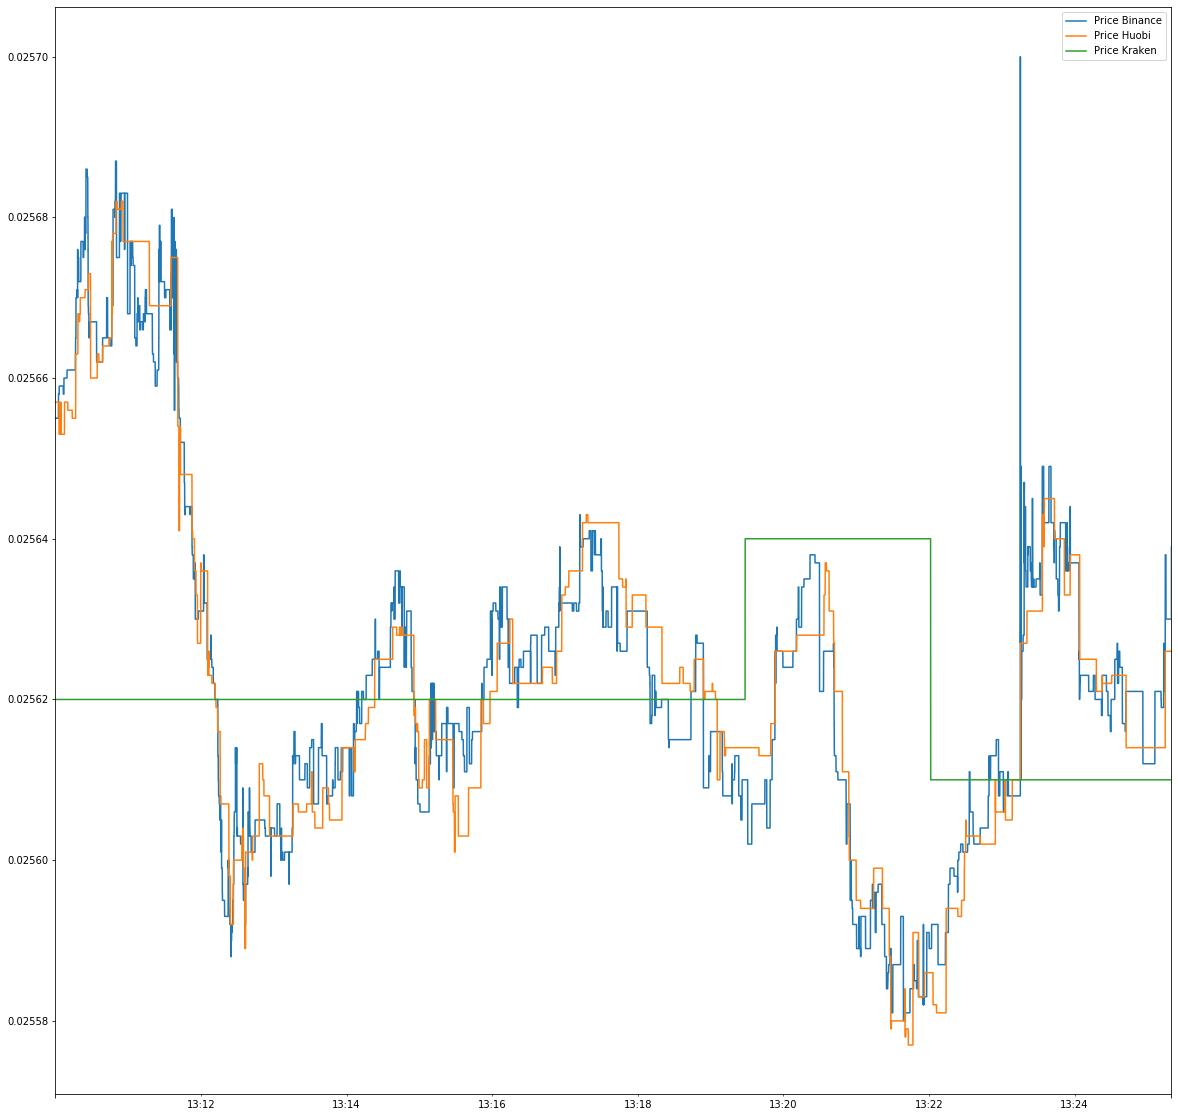

In [35]:
df2[["Price Binance", "Price Huobi", "Price Kraken"]].plot()

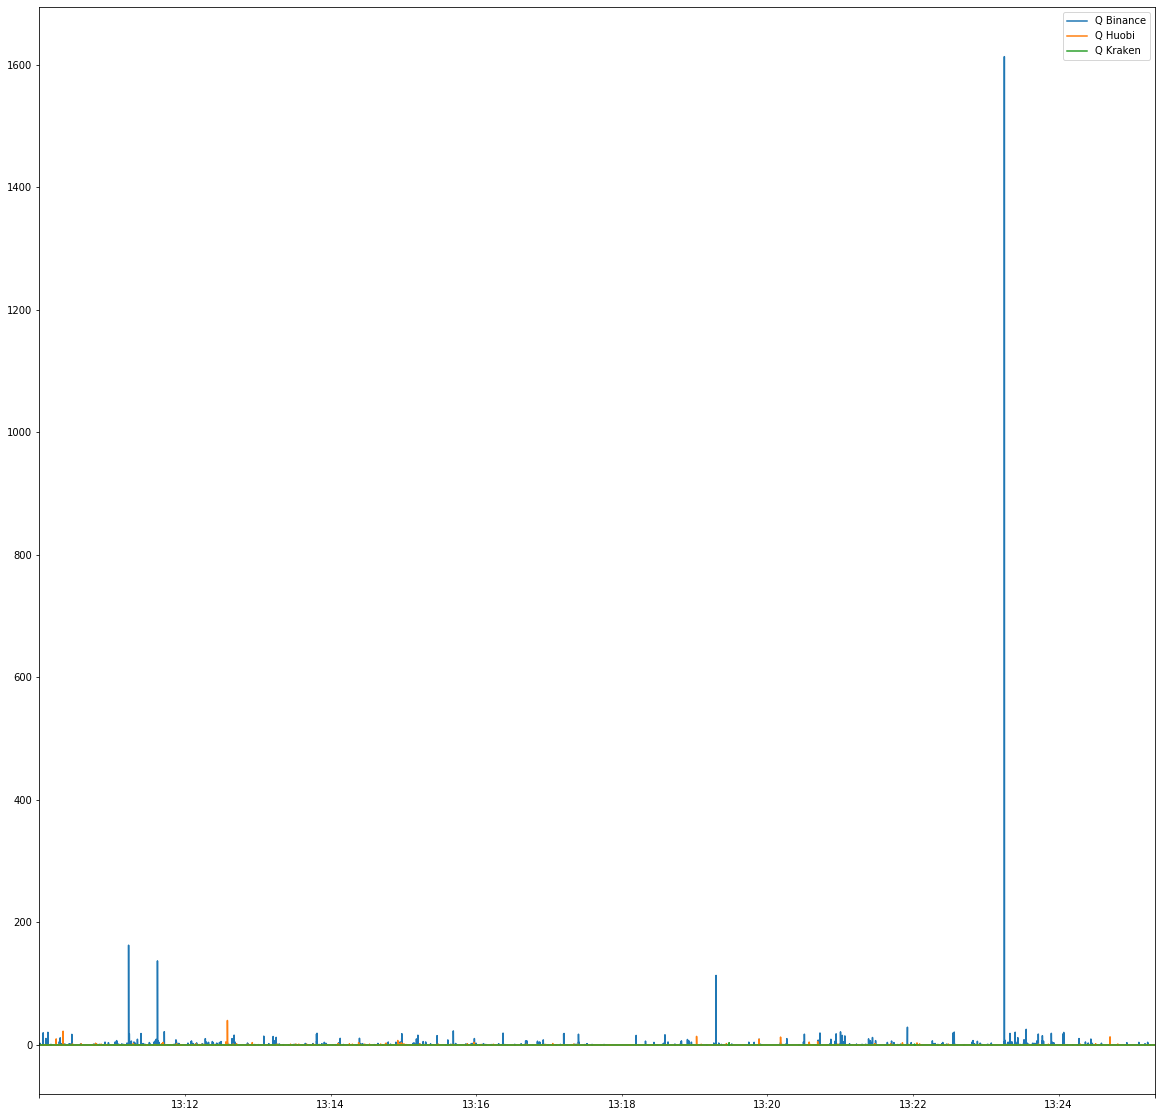

In [37]:
df2[["Q Binance","Q Huobi", "Q Kraken"]].plot()

From here I'm thinking in computing different price differences metrics (Maximum difference over intervals, voulmes...)
Maybe an LSTM using the previous data of last trades to predict 

# Check order books

In [38]:
# Remove possible duplicates
points_book = client.query("SELECT * FROM Book WHERE time > '2020-04-29 13:00:00'")
points_book["Book"]

,Asks,Bids,Host,LastUpdateID,Pair
2020-04-29 13:07:00.256999936+00:00,"[['0.02567778', '7.74140994'], ['0.02568119', ...","[['0.02563921', '14.94586204'], ['0.02563920',...",Bitstamp,1588158421784088,ethbtc
2020-04-29 13:07:00.364000+00:00,"[['8155.97', '14.64698753'], ['8156.00', '0.36...","[['8150.89', '4.00000000'], ['8150.87', '0.017...",Bitstamp,1588158421926082,btcusd
2020-04-29 13:07:00.537999872+00:00,"[['0.0257040000', '0.807733'], ['0.0258120000'...","[['0.0255850000', '0.316888'], ['0.0254570000'...",Bithumb,1588158422022,ethbtc
2020-04-29 13:07:00.569999872+00:00,"[['0.02567778', '7.74140994'], ['0.02568038', ...","[['0.02563925', '14.94586204'], ['0.02563921',...",Bitstamp,1588158422047647,ethbtc
2020-04-29 13:07:00.623000064+00:00,"[['8156.00', '0.36782917'], ['8158.00', '1.000...","[['8150.89', '4.00000000'], ['8150.87', '0.017...",Bitstamp,1588158422102230,btcusd
...,...,...,...,...,...
2020-04-29 13:25:26.948000+00:00,"[[0.025637, 0.3195], [0.025638, 24.0], [0.0256...","[[0.025631, 39.1561], [0.02563, 2.5], [0.02562...",Huobi,1588159526771,ethbtc
2020-04-29 13:25:27.923000064+00:00,"[[0.025637, 0.3195], [0.025638, 29.06], [0.025...","[[0.025631, 39.1561], [0.02563, 2.5], [0.02562...",Huobi,1588159527771,ethbtc
2020-04-29 13:25:29.059000064+00:00,"[[0.025637, 0.3195], [0.025638, 31.4232], [0.0...","[[0.025631, 39.1561], [0.02563, 2.5], [0.02562...",Huobi,1588159528772,ethbtc
2020-04-29 13:25:29.920000+00:00,"[[0.025637, 0.3195], [0.025638, 31.4232], [0.0...","[[0.025631, 39.1561], [0.02563, 2.0], [0.02562...",Huobi,1588159529774,ethbtc


In [39]:
np.unique(points_book["Book"]["Host"])

array(['Binance', 'BitFlyer', 'Bitfinex', 'Bithumb', 'Bitstamp',
       'Coinbase', 'Huobi', 'Kraken'], dtype=object)

In [40]:
#Check for duplicates
dup_number = np.sum(points_book["Book"].reset_index().duplicated())
if dup_number != 0:
    points["Book"][points_book["Book"].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


In [41]:
points_dif = client.query("SELECT * FROM difBook WHERE time > '2020-04-24 22:00:00'")

dup_number = np.sum(points_dif["difBook"].reset_index().duplicated())

if dup_number != 0:
    points_dif["difBook"][points_dif["difBook"].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


In [42]:
np.unique(points_dif["difBook"]["Host"])
# Huobi is not here because we are gathering the order book by second in the previous table.
# It was way too messy to try to gather the differential order book. I will do it if I have spare time only.

array(['Binance', 'BitFlyer', 'Bitfinex', 'Bithumb', 'Bitstamp',
       'Coinbase', 'Kraken'], dtype=object)

Exploring Binance OrderBook

In [43]:
# First snapshots
dfT = points_book["Book"]
d = dfT[dfT["Host"] == "Binance"]
d

,Asks,Bids,Host,LastUpdateID,Pair
2020-04-29 13:07:14.548000+00:00,"[['0.02565900', '23.81600000'], ['0.02566000',...","[['0.02565700', '5.32500000'], ['0.02565600', ...",Binance,1177990271,ethbtc
2020-04-29 13:07:26.216000+00:00,"[['0.02566300', '0.37100000'], ['0.02566400', ...","[['0.02566200', '24.00000000'], ['0.02566100',...",Binance,1177990813,ethbtc
2020-04-29 13:07:37.719000064+00:00,"[['0.02566800', '20.52900000'], ['0.02566900',...","[['0.02566500', '275.73600000'], ['0.02566400'...",Binance,1177991292,ethbtc
2020-04-29 13:08:00.472000+00:00,"[['0.02566300', '4.42700000'], ['0.02566400', ...","[['0.02565400', '0.36600000'], ['0.02565300', ...",Binance,1177992223,ethbtc
2020-04-29 13:09:48.308999936+00:00,"[['0.02564400', '0.82100000'], ['0.02564500', ...","[['0.02563900', '17.23600000'], ['0.02563800',...",Binance,1177995189,ethbtc
2020-04-29 13:15:04.836000+00:00,"[['0.02561300', '7.91900000'], ['0.02561800', ...","[['0.02560900', '24.00000000'], ['0.02560800',...",Binance,1178009477,ethbtc
2020-04-29 13:17:42.596999936+00:00,"[['0.02563400', '23.87300000'], ['0.02563500',...","[['0.02562700', '0.55000000'], ['0.02562600', ...",Binance,1178014206,ethbtc
2020-04-29 13:20:21.259000064+00:00,"[['0.02563800', '24.00000000'], ['0.02563900',...","[['0.02563100', '0.55600000'], ['0.02563000', ...",Binance,1178018344,ethbtc
2020-04-29 13:23:01.457999872+00:00,"[['0.02560900', '0.16700000'], ['0.02561000', ...","[['0.02560600', '84.04100000'], ['0.02560500',...",Binance,1178023683,ethbtc


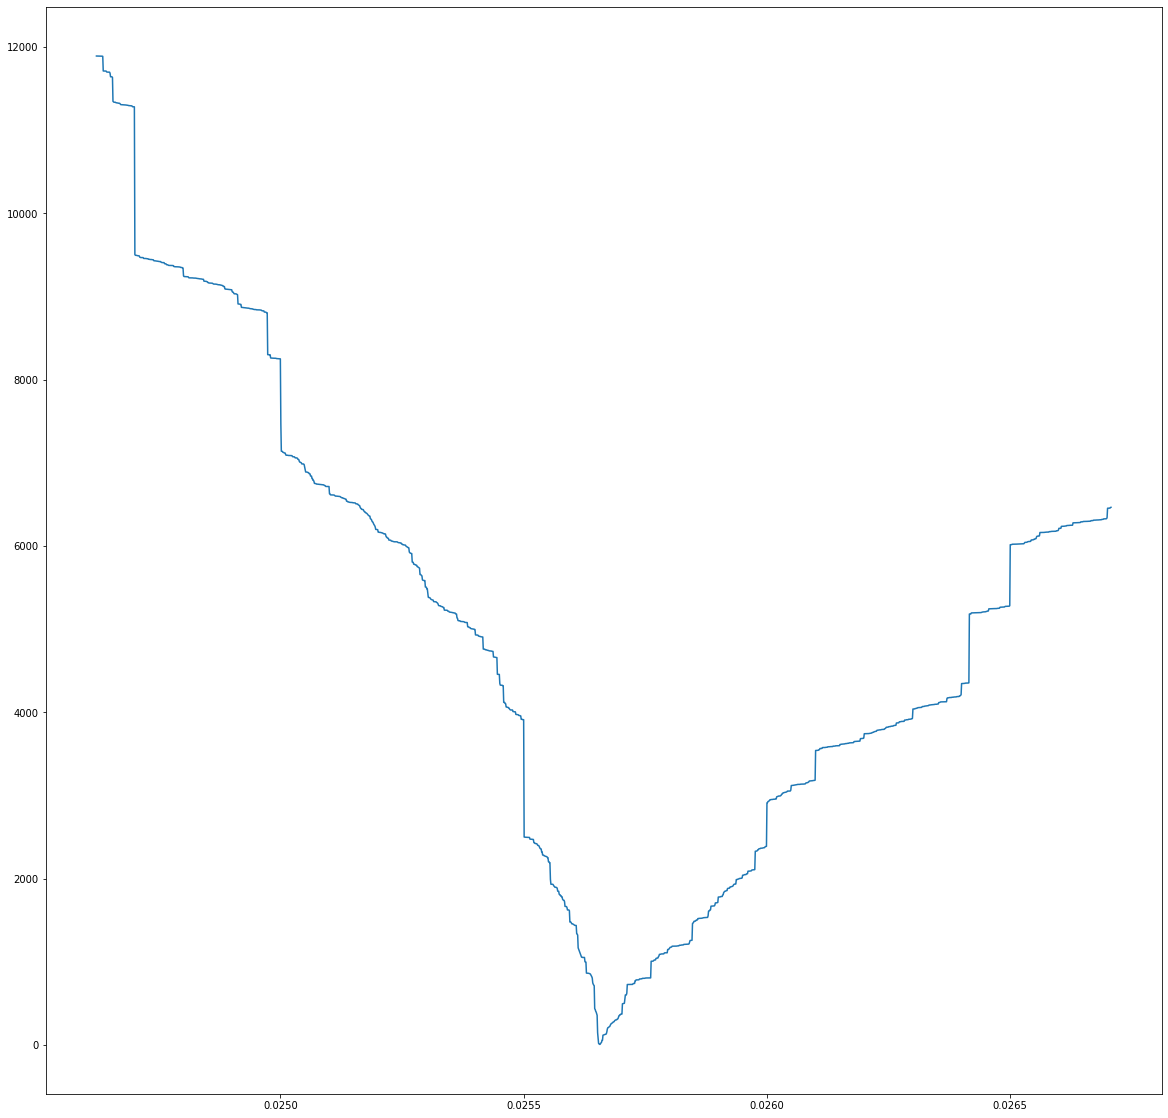

In [44]:
bids = d.iloc[:,0].apply(lambda x: [[float(j) for j in i] for i in ast.literal_eval(x)])[0]
asks = d.iloc[:,1].apply(lambda x: [[float(j) for j in i] for i in ast.literal_eval(x)])[0]
# print(bids)
# print("ASKS")
# print(asks)
price_b = [bids[i][0] for i in range(len(bids))]
price_a = [asks[-(i+1)][0] for i in range(len(asks))]
# print("PRICESS")
# print(price_b)
price = price_a + price_b

freq_b = np.cumsum([bids[i][1] for i in range(len(bids))]).tolist()
freq_a = np.cumsum([asks[i][1] for i in range(len(asks))])[::-1].tolist()

freq = freq_a + freq_b
plt.plot(price,freq)

In [45]:
df = points_dif["difBook"]
df[df["Host"] == "Binance"]["Seg"]

2020-04-29 13:07:01.944000+00:00       [1177989580, 1177989541]
2020-04-29 13:07:02.944000+00:00       [1177989641, 1177989581]
2020-04-29 13:07:07.944000+00:00       [1177989923, 1177989890]
2020-04-29 13:07:10.944000+00:00       [1177990067, 1177990038]
2020-04-29 13:07:11.944000+00:00       [1177990107, 1177990068]
                                                 ...           
2020-04-29 13:25:01.953999872+00:00    [1178028207, 1178028188]
2020-04-29 13:25:09.953999872+00:00    [1178028415, 1178028388]
2020-04-29 13:25:11.953999872+00:00    [1178028455, 1178028436]
2020-04-29 13:25:24.953999872+00:00    [1178029028, 1178029007]
2020-04-29 13:25:25.953999872+00:00    [1178029075, 1178029029]
Name: Seg, Length: 100, dtype: object

In [46]:
difBin = df[df["Host"] == "Binance"][["Asks", "Bids", "Pair", "Seg"]]
difBin["Seg"] = difBin["Seg"].apply(lambda x: ast.literal_eval(x))
difBin

,Asks,Bids,Pair,Seg
2020-04-29 13:07:01.944000+00:00,"[['0.02566000', '0.00000000'], ['0.02566100', ...","[['0.02565700', '0.27400000'], ['0.02565500', ...",ethbtc,"[1177989580, 1177989541]"
2020-04-29 13:07:02.944000+00:00,"[['0.02566100', '0.00600000'], ['0.02566200', ...","[['0.02565900', '23.71800000'], ['0.02565800',...",ethbtc,"[1177989641, 1177989581]"
2020-04-29 13:07:07.944000+00:00,"[['0.02566500', '0.90900000'], ['0.02566600', ...","[['0.02566500', '0.00000000'], ['0.02566200', ...",ethbtc,"[1177989923, 1177989890]"
2020-04-29 13:07:10.944000+00:00,"[['0.02566500', '0.57700000'], ['0.02566600', ...","[['0.02566200', '287.34200000'], ['0.02566100'...",ethbtc,"[1177990067, 1177990038]"
2020-04-29 13:07:11.944000+00:00,"[['0.02566300', '21.46400000'], ['0.02566400',...","[['0.02566200', '1.40600000'], ['0.02566100', ...",ethbtc,"[1177990107, 1177990068]"
...,...,...,...,...
2020-04-29 13:25:01.953999872+00:00,"[['0.02561600', '0.00000000'], ['0.02561700', ...","[['0.02561100', '5.41900000'], ['0.02560900', ...",ethbtc,"[1178028207, 1178028188]"
2020-04-29 13:25:09.953999872+00:00,"[['0.02562300', '0.00000000'], ['0.02562400', ...","[['0.02562000', '2.51500000'], ['0.02561900', ...",ethbtc,"[1178028415, 1178028388]"
2020-04-29 13:25:11.953999872+00:00,"[['0.02562400', '0.70700000'], ['0.02562600', ...","[['0.02562000', '0.00000000'], ['0.02561900', ...",ethbtc,"[1178028455, 1178028436]"
2020-04-29 13:25:24.953999872+00:00,"[['0.02563900', '20.37800000'], ['0.02564100',...","[['0.02563500', '0.00100000'], ['0.02563200', ...",ethbtc,"[1178029028, 1178029007]"


In [47]:
# Number of jumps where we have no data
jumps = np.asarray([difBin["Seg"][i][0]+1 == difBin["Seg"].shift(-1)[i][1] for i in range(0,len(difBin)-1)])
jumps2 = np.asarray([[difBin["Seg"][i][0]+1, difBin["Seg"].shift(-1)[i][1]] for i in range(0,len(difBin)-1)])
print(np.sum([difBin["Seg"][i][0]+1 == difBin["Seg"].shift(-1)[i][1] for i in range(0,len(difBin)-1)]))
print(len(jumps))
jumps2[False == jumps]


7
99


array([[1177989642, 1177989890],
       [1177989924, 1177990038],
       [1177990108, 1177990321],
       [1177990380, 1177990669],
       [1177990743, 1177990890],
       [1177990911, 1177991291],
       [1177991313, 1177991353],
       [1177991422, 1177991799],
       [1177991833, 1177992182],
       [1177992206, 1177992281],
       [1177992294, 1177992401],
       [1177992430, 1177992590],
       [1177992616, 1177992633],
       [1177992645, 1177992707],
       [1177992778, 1177992791],
       [1177992861, 1177992885],
       [1177992897, 1177992997],
       [1177993042, 1177993160],
       [1177993176, 1177993442],
       [1177993454, 1177994192],
       [1177994210, 1177994927],
       [1177994938, 1177995016],
       [1177995036, 1177995751],
       [1177995778, 1177995850],
       [1177995872, 1177995941],
       [1177995952, 1177996884],
       [1177996905, 1177997796],
       [1177997839, 1177998683],
       [1177998707, 1177999518],
       [1177999540, 1177999664],
       [11

The idea would be to add to the dataframe of the previous part metrics from each order book in order to train the model

In [ ]:
# Try to recompute order book
# Create the class for reconstruct
# Models??

# Statistical Tests

In [ ]:
# Do a POC with data extracted from REST for triangular, and tests.
# Calculate differences by 5 seconds interval
# 